 # Power Load Prediction for West Zone - Linear Model (30 Min)

In [52]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [53]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_91036/1727164072.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  power_data_west = pd.read_csv("westdata_augmented.csv")


In [54]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [55]:
power_data_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [56]:
power_data_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [57]:
power_data_west.head()

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,sfm,index_y,dt,dt_iso,humidity,humidity_temp,pt_date
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01


In [58]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [59]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [60]:
power_data_west['day_of_week'] = power_data_west['end'].dt.day_name()

In [61]:
power_data_west['day_of_week_int'] = power_data_west['end'].dt.day_of_week

In [62]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_range = pd.date_range(start='2019-01-01', end='2022-01-27')

cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

power_data_west['holiday'] = power_data_west['end'].dt.date.astype('datetime64').isin(holidays)

In [63]:
power_data_west["holiday_int"] = power_data_west["holiday"].astype(int)

In [64]:
power_data_west_mod = power_data_west[['end','demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [65]:
power_data_west_mod.head()

,end,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,2019-01-29 00:15:00,844.8,54.0,21,1,1,0
1,2019-01-29 00:30:00,841.6,54.0,21,1,1,0
2,2019-01-29 00:45:00,832.0,54.0,21,1,1,0
3,2019-01-29 01:00:00,848.0,54.0,21,1,1,0
4,2019-01-29 01:15:00,812.8,55.0,21,1,1,0


In [66]:
power_data_west_mod.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,104596.000000,104588.00000,104608.000000,104608.00000,104608.000000,104608.000000
mean,1238.634456,67.39232,52.635401,6.54298,2.998748,0.028449
std,302.399419,16.59371,22.815913,3.43464,2.002753,0.166253
min,0.000000,29.00000,3.000000,1.00000,0.000000,0.000000
25%,1008.000000,54.00000,34.000000,4.00000,1.000000,0.000000
50%,1232.000000,66.00000,49.000000,7.00000,3.000000,0.000000
75%,1472.000000,79.00000,70.000000,10.00000,5.000000,0.000000
max,2124.800000,114.00000,100.000000,12.00000,6.000000,1.000000


In [67]:
power_data_west_mod.shape

(104608, 7)

In [68]:
power_data_west_30M = power_data_west_mod.resample('30T', on='end').agg({'demand':'sum', 'temp':'mean', 'humidity':'mean', 'month_int':'max', 'day_of_week_int':'max', 'holiday_int':'max'})

In [69]:
power_data_west_30M.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
end,,,,,,
2019-01-29 00:00:00,844.8,54.0,21.0,1,1.0,0.0
2019-01-29 00:30:00,1673.6,54.0,21.0,1,1.0,0.0
2019-01-29 01:00:00,1660.8,54.5,21.0,1,1.0,0.0
2019-01-29 01:30:00,1644.8,55.0,21.0,1,1.0,0.0
2019-01-29 02:00:00,1705.6,55.0,21.5,1,1.0,0.0
2019-01-29 02:30:00,1824.0,55.0,22.0,1,1.0,0.0
2019-01-29 03:00:00,1740.8,54.5,22.5,1,1.0,0.0
2019-01-29 03:30:00,1692.8,54.0,23.0,1,1.0,0.0
2019-01-29 04:00:00,1628.8,54.0,23.5,1,1.0,0.0


In [70]:
power_data_west_30M.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,52449.000000,52303.000000,52308.000000,52308.000000,52308.000000,52308.000000
mean,2470.136887,67.390006,52.636719,6.542785,2.998738,0.028447
std,616.494929,16.560147,22.674339,3.434836,2.002713,0.166247
min,0.000000,29.000000,3.000000,1.000000,0.000000,0.000000
25%,2009.600000,54.000000,34.500000,4.000000,1.000000,0.000000
50%,2460.800000,66.000000,49.000000,7.000000,3.000000,0.000000
75%,2944.000000,79.000000,70.000000,10.000000,5.000000,0.000000
max,4233.600000,114.000000,100.000000,12.000000,6.000000,1.000000


In [71]:
power_data_west_30M = power_data_west_30M[['demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [72]:
for i in range(1, 10):
    power_data_west_30M["demand_lag_{}".format(i)] = power_data_west_30M['demand'].shift(i)
    power_data_west_30M["temp_lag_{}".format(i)] = power_data_west_30M['temp'].shift(i)
    power_data_west_30M["humidity_lag_{}".format(i)] = power_data_west_30M['humidity'].shift(i)

In [73]:
power_data_west_30M.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,demand_lag_1,temp_lag_1,humidity_lag_1,demand_lag_2,...,humidity_lag_6,demand_lag_7,temp_lag_7,humidity_lag_7,demand_lag_8,temp_lag_8,humidity_lag_8,demand_lag_9,temp_lag_9,humidity_lag_9
end,,,,,,,,,,,,,,,,,,,,,
2019-01-29 00:00:00,844.8,54.0,21.0,1,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 00:30:00,1673.6,54.0,21.0,1,1.0,0.0,844.8,54.0,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 01:00:00,1660.8,54.5,21.0,1,1.0,0.0,1673.6,54.0,21.0,844.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 01:30:00,1644.8,55.0,21.0,1,1.0,0.0,1660.8,54.5,21.0,1673.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 02:00:00,1705.6,55.0,21.5,1,1.0,0.0,1644.8,55.0,21.0,1660.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 02:30:00,1824.0,55.0,22.0,1,1.0,0.0,1705.6,55.0,21.5,1644.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 03:00:00,1740.8,54.5,22.5,1,1.0,0.0,1824.0,55.0,22.0,1705.6,...,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 03:30:00,1692.8,54.0,23.0,1,1.0,0.0,1740.8,54.5,22.5,1824.0,...,21.0,844.8,54.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29 04:00:00,1628.8,54.0,23.5,1,1.0,0.0,1692.8,54.0,23.0,1740.8,...,21.0,1673.6,54.0,21.0,844.8,54.0,21.0,NaN,NaN,NaN


In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [75]:
def timeseries_train_test_split(X, y, test_size):
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

dataset.kW.plot()

In [76]:
y = power_data_west_30M.dropna()['demand']
X = power_data_west_30M.dropna().drop(['demand'], axis=1)

In [77]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [78]:
X_train.shape

(36555, 32)

In [79]:
y_train.shape

(36555,)

In [80]:
X_test.shape

(15667, 32)

In [81]:
y_test.shape

(15667,)

In [82]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)

LinearRegression()

In [83]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def mse_error(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=True)

def rmse_error(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=False)

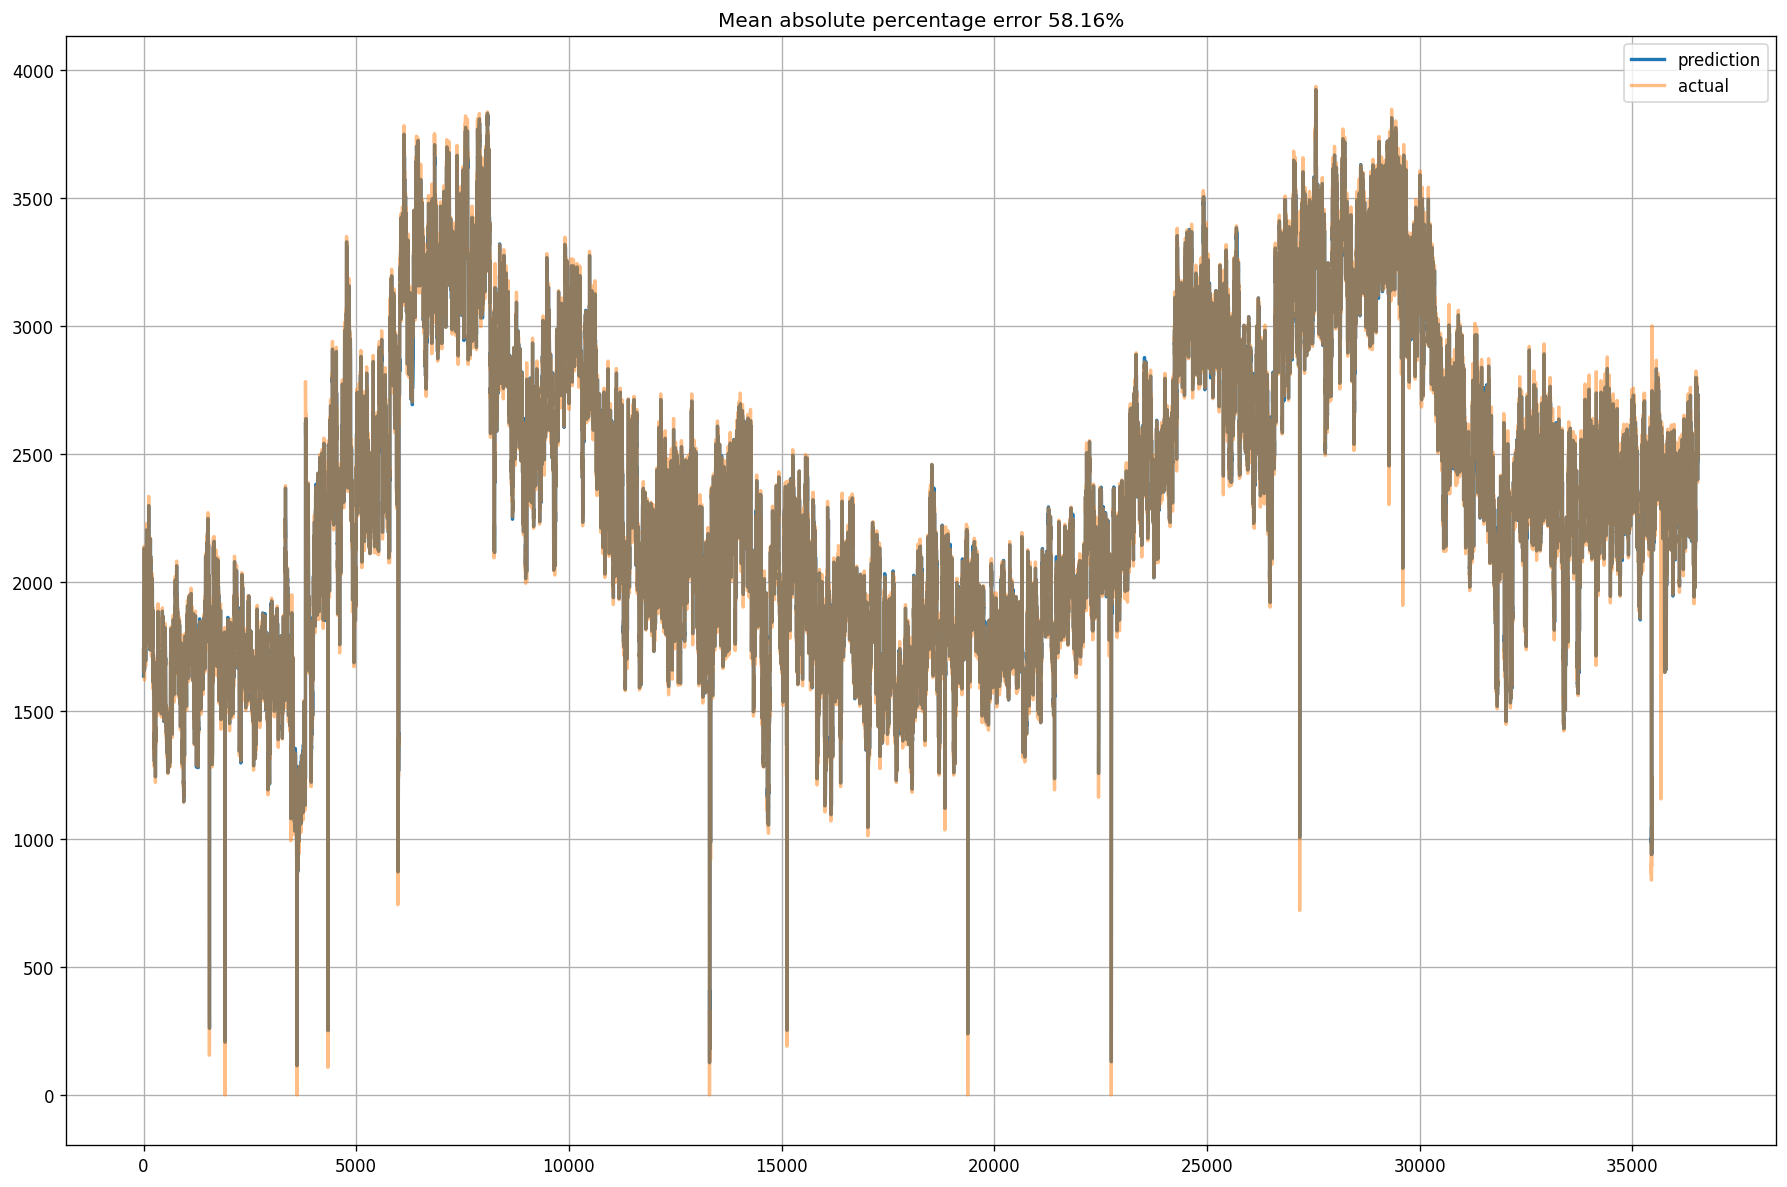

In [84]:
def plotModelTrainingResults(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(prediction, y_train)
    mae_error_var = mean_absolute_error(prediction, y_train)
    mse_error_var = mse_error(prediction, y_train)
    rmse_error_var = rmse_error(prediction, y_train)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mae_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_train, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
train_results, train_mape_error_var, train_mae_error_var, train_mse_error_var, train_rmse_error_var = plotModelTrainingResults(lr)

In [85]:
train_results['residual'] = train_results['Actual'] - train_results['Prediction']

In [86]:
train_results.tail(10)

,Actual,Prediction,residual
end,,,
2021-03-02 08:00:00,2604.8,2535.877750,68.922250
2021-03-02 08:30:00,2550.4,2614.204823,-63.804823
2021-03-02 09:00:00,2595.2,2575.681276,19.518724
2021-03-02 09:30:00,2636.8,2615.929335,20.870665
2021-03-02 10:00:00,2547.2,2657.380927,-110.180927
2021-03-02 10:30:00,2643.2,2577.976457,65.223543
2021-03-02 11:00:00,2665.6,2658.859360,6.740640
2021-03-02 11:30:00,2649.6,2677.632968,-28.032968
2021-03-02 12:00:00,2716.8,2664.519009,52.280991


<AxesSubplot:xlabel='end'>

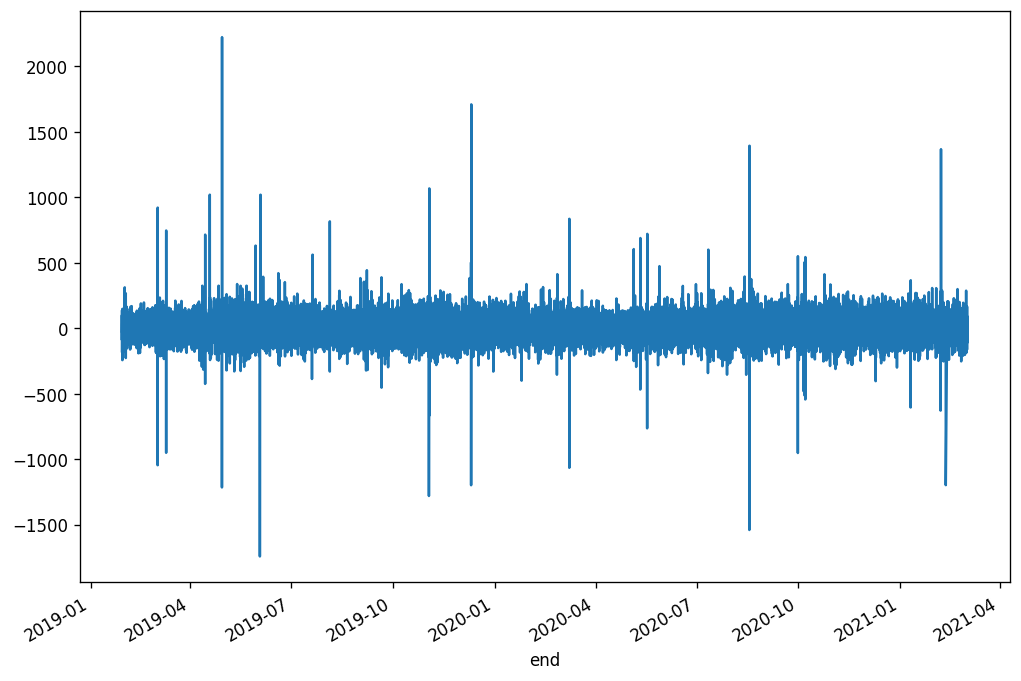

In [87]:
train_results['residual'].plot()

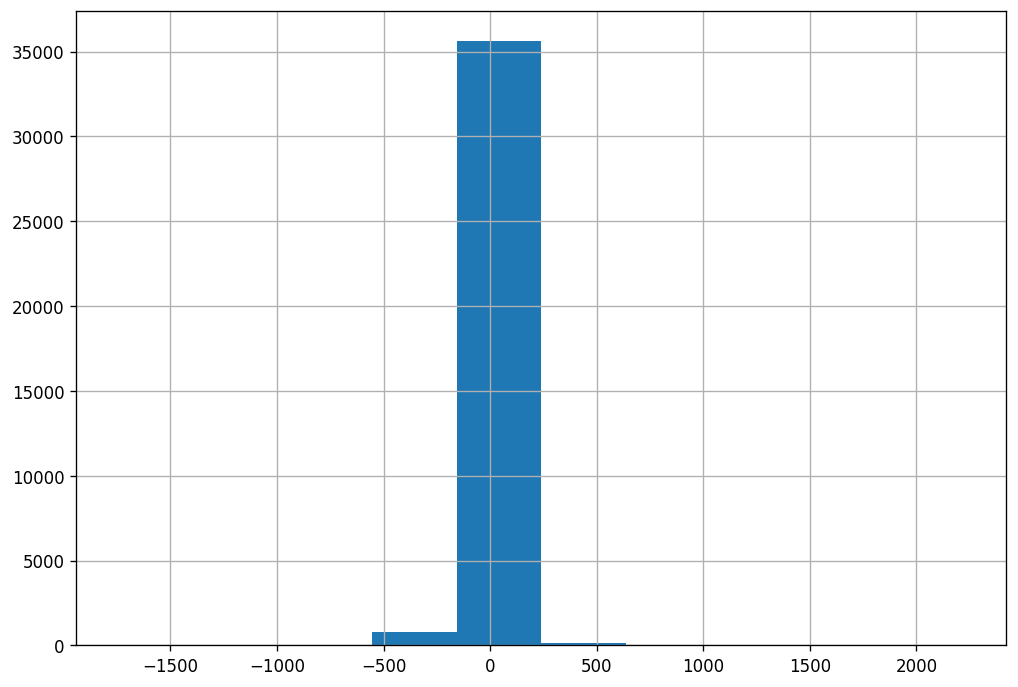

In [88]:
train_results['residual'].hist()
plt.show()

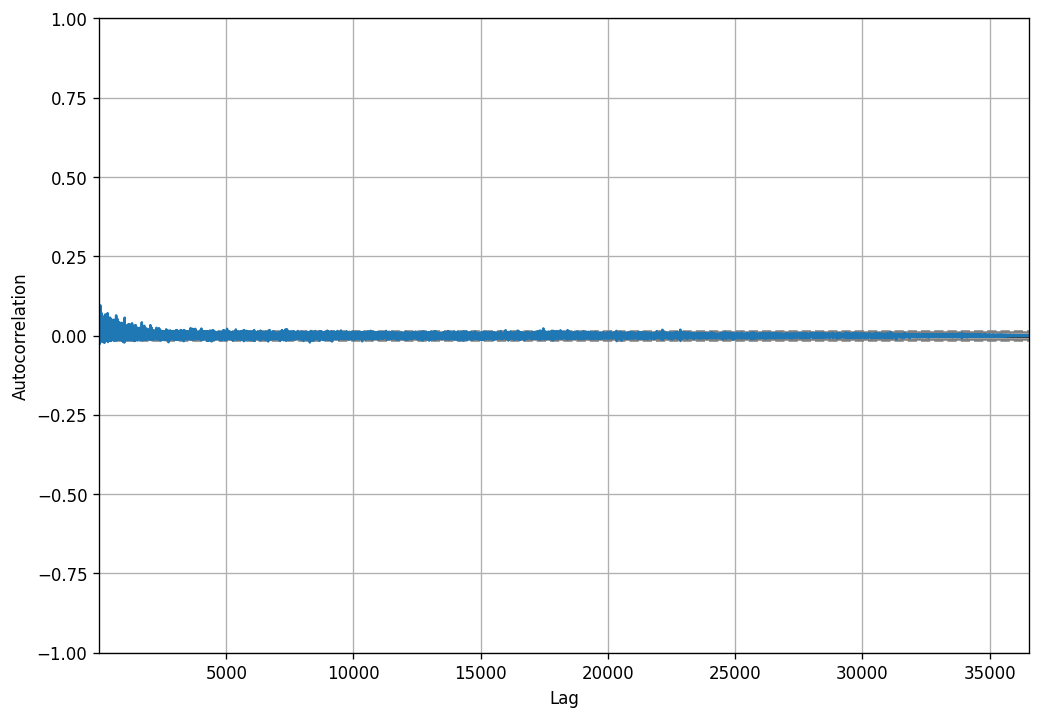

In [89]:
# autocorrelation
autocorrelation_plot(train_results['residual'])
plt.show()

In [90]:
print('MAPE: ' , train_mape_error_var)
print('MAE: ', train_mae_error_var)
print('MSE: ', train_mse_error_var)
print('RMSE: ', train_rmse_error_var)

MAPE:  2.7366709216140777
MAE:  58.16314251431508
MSE:  7017.599402502283
RMSE:  83.77111317454414


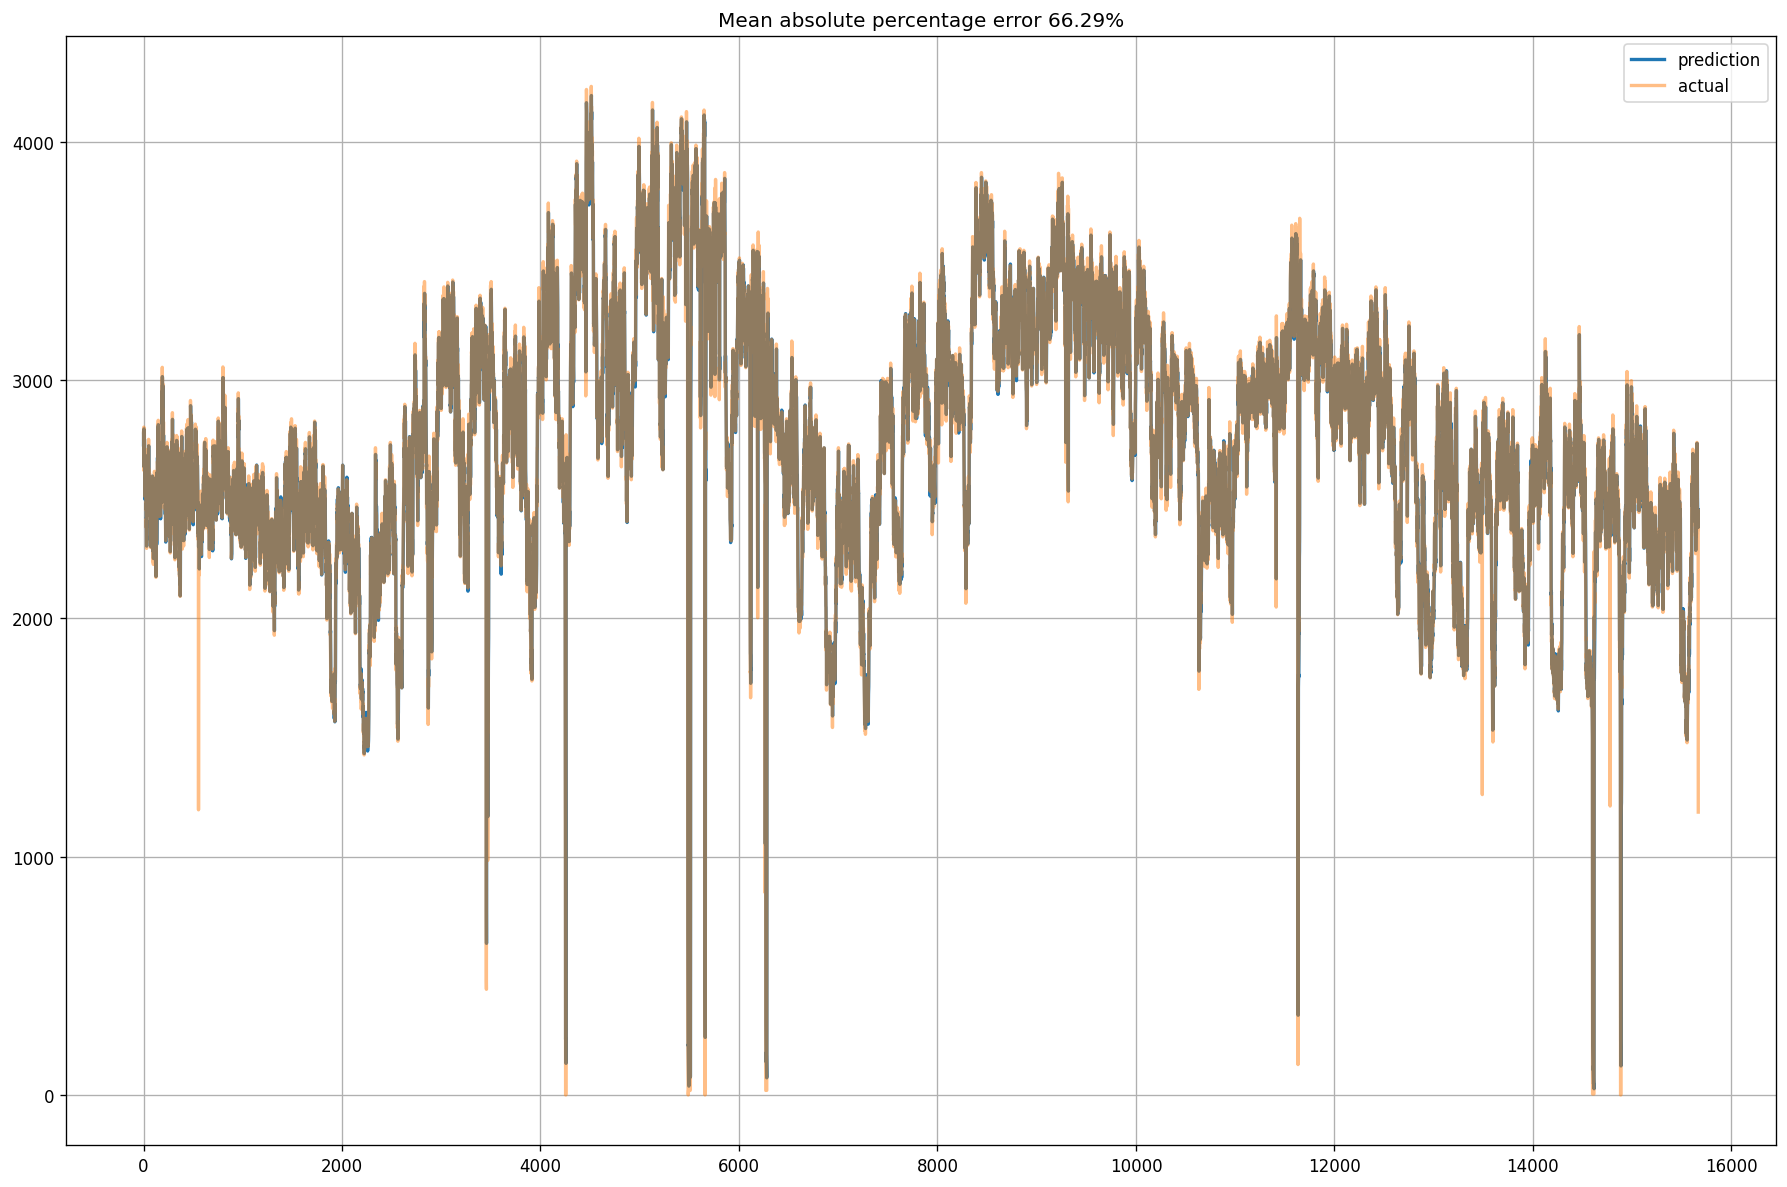

In [91]:
def plotModelPredictions(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(prediction, y_test)
    mae_error_var = mean_absolute_error(prediction, y_test)
    mse_error_var = mse_error(prediction, y_test)
    rmse_error_var = rmse_error(prediction, y_test)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mae_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_test, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var = plotModelPredictions(lr)

In [92]:
results['residual'] = results['Actual'] - results['Prediction']

In [93]:
results.tail(10)

,Actual,Prediction,residual
end,,,
2022-01-25 11:30:00,2473.6,2554.725660,-81.125660
2022-01-25 12:00:00,2425.6,2510.264799,-84.664799
2022-01-25 12:30:00,2412.8,2463.675019,-50.875019
2022-01-25 13:00:00,2396.8,2443.897737,-47.097737
2022-01-25 13:30:00,2425.6,2427.608324,-2.008324
2022-01-25 14:00:00,2403.2,2445.133863,-41.933863
2022-01-25 14:30:00,2428.8,2424.043350,4.756650
2022-01-25 15:00:00,2371.2,2440.520495,-69.320495
2022-01-25 15:30:00,2457.6,2382.400523,75.199477


<AxesSubplot:xlabel='end'>

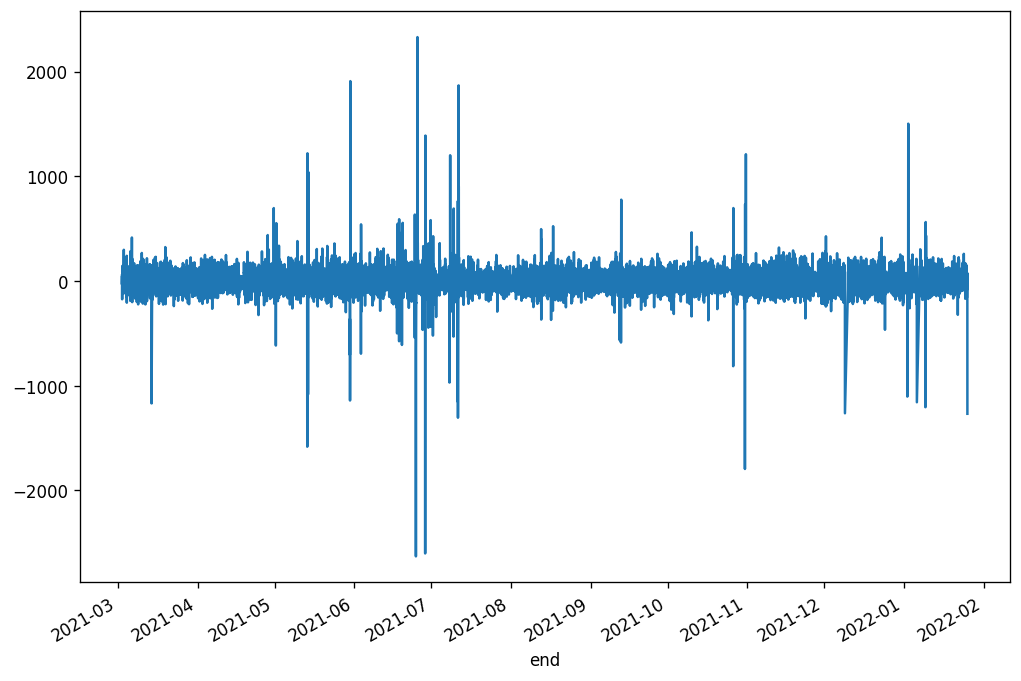

In [94]:
results['residual'].plot()

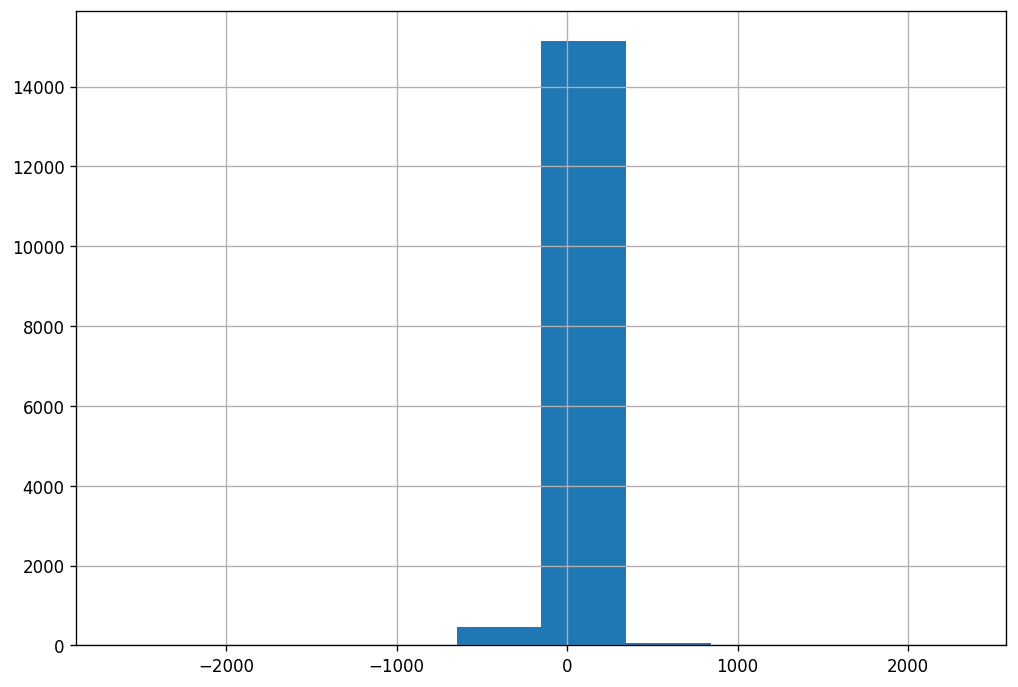

In [95]:
results['residual'].hist()
plt.show()

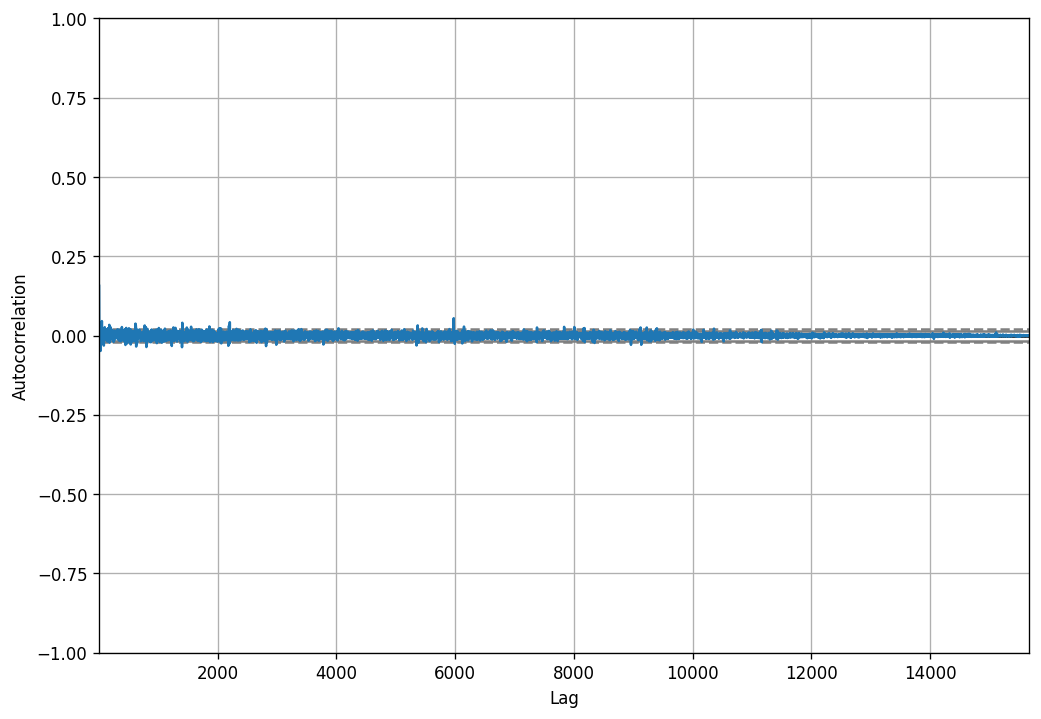

In [96]:
autocorrelation_plot(results['residual'])
plt.show()

In [97]:
print('MAPE: ' , mape_error_var)
print('MAE: ', mae_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

MAPE:  3.3579879418470897
MAE:  66.29471571041002
MSE:  12093.595923095081
RMSE:  109.9708867068693


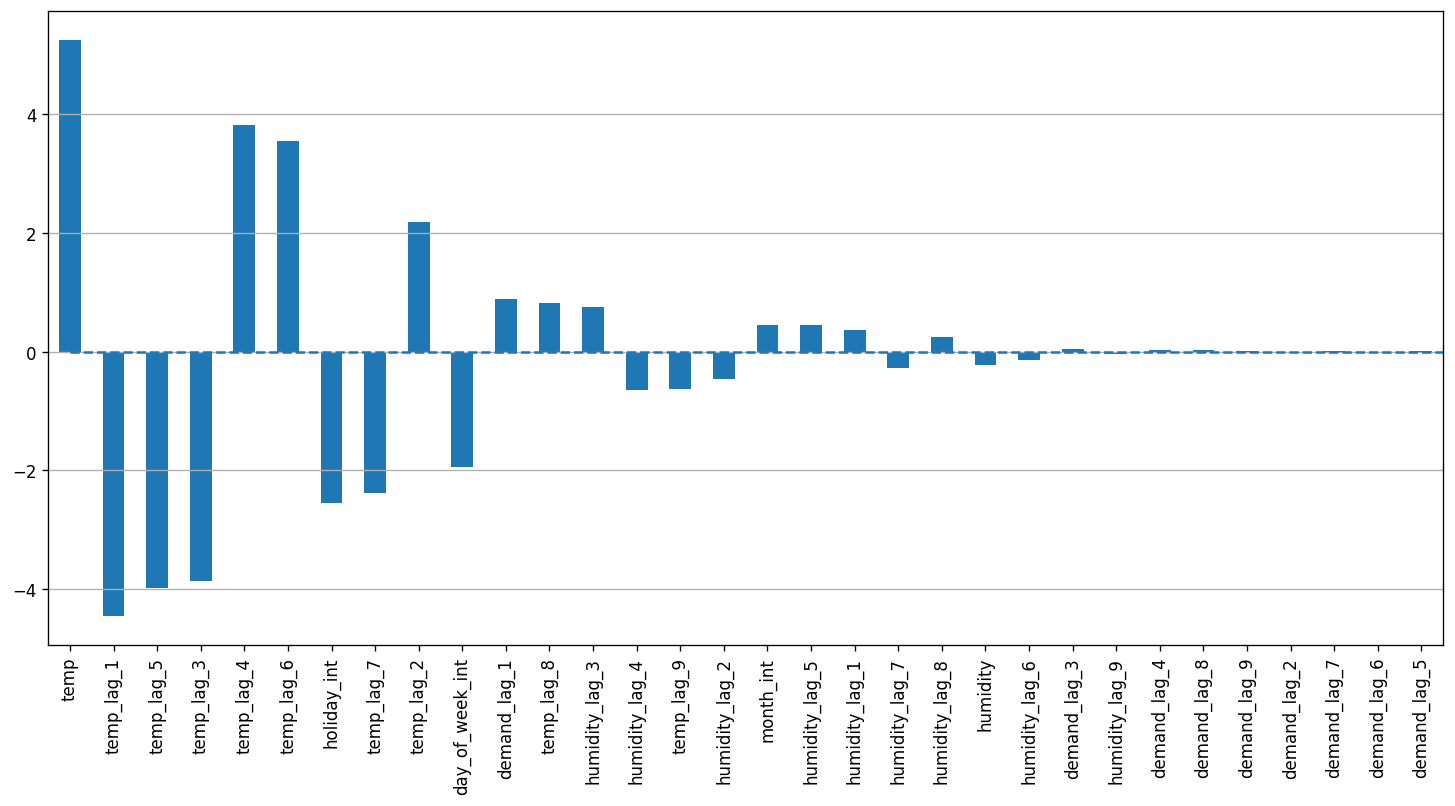

In [98]:
def plotCoefficients(model, maxDisplayValues=50):
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    plot_coefs = coefs.head(maxDisplayValues)
    
    plt.figure(figsize=(15, 7))
    plot_coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(plot_coefs), linestyles='dashed');

plotCoefficients(lr)